In [10]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

import metpy

sys.path.append('/pyBKB_v3')
'''
from BB_GOES.get_GOES import get_GOES_nearesttime

DATE = datetime(2019, 4, 17, 15)

# This functin gets the nearest file name and path on our local disk. 
# You might want to download GOES files from Amazon.
file16 = get_GOES_nearesttime(DATE, product='ABI', satellite=16, verbose=False)
file17 = get_GOES_nearesttime(DATE, product='ABI', satellite=17, verbose=False)
'''
G16 = xarray.open_dataset('OR_ABI-L2-MCMIPC-M6_G16_s20191771701200_e20191771703573_c20191771704096.nc')
G17 = xarray.open_dataset('OR_ABI-L2-MCMIPC-M6_G17_s20191771701197_e20191771703570_c20191771704070.nc')


In [8]:
!conda install netcdf4 -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.5

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/adomakor412/.conda/envs/GOESCode

  added / updated specs: 
    - netcdf4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    curl-7.64.1                |       hbc83047_0         138 KB
    cftime-1.0.3.4             |   py37hdd07704_1         307 KB
    hdf5-1.10.4                |       hb1b8bf9_0         5.3 MB
    libcurl-7.64.1             |       h20c2e04_0         582 KB
    netcdf4-1.4.2              |   py37h808af73_0         528 KB
    krb5-1.16.1                |       h173b8e3_7         1.4 MB
    libnetcdf-4.6.1            |       h11d0813_2         1.3 MB
    libssh2-1.8.2              |       h1ba5d50_0         250 KB
 

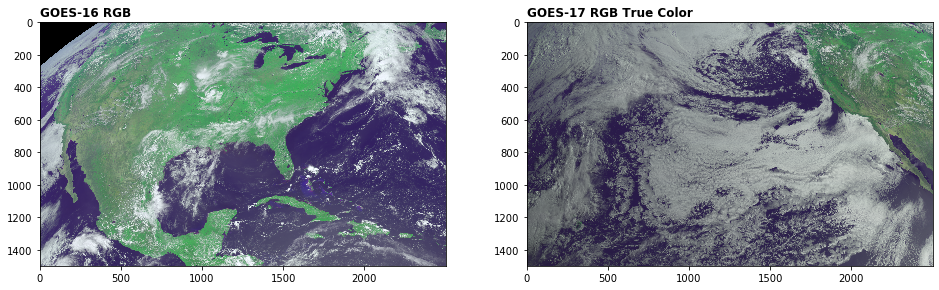

In [16]:
R_16 = G16['CMI_C02'].data
G_16 = G16['CMI_C03'].data
B_16 = G16['CMI_C01'].data
R_17 = G17['CMI_C02'].data
G_17 = G17['CMI_C03'].data
B_17 = G17['CMI_C01'].data


R_16 = np.clip(R_16, 0, 1)
G_16 = np.clip(G_16, 0, 1)
B_16 = np.clip(B_16, 0, 1)
R_17 = np.clip(R_17, 0, 1)
G_17 = np.clip(G_17, 0, 1)
B_17 = np.clip(B_17, 0, 1)

gamma = 2.2
R_16 = np.power(R_16, 1/gamma)
G_16 = np.power(G_16, 1/gamma)
B_16 = np.power(B_16, 1/gamma)
R_17 = np.power(R_17, 1/gamma)
G_17 = np.power(G_17, 1/gamma)
B_17 = np.power(B_17, 1/gamma)

RGB_16 = np.dstack([R_16, G_16, B_16])#making the 3D array [,,]
RGB_17 = np.dstack([R_17, G_17, B_17])#making the 3D array [,,]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.imshow(RGB_16)
ax1.set_title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=12);

ax2.imshow(RGB_17)
ax2.set_title('GOES-17 RGB True Color', fontweight='semibold', loc='left', fontsize=12);


In [3]:

def make_RGB(C, night_IR=True):
    """
    C        - GOES file opened with xarray
    night_IR - Set nighttime pixels as clean IR channel (channel 13, 10.3 um).
    """
    
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C02'].data
    G = C['CMI_C03'].data
    B = C['CMI_C01'].data

    ######################################################################
    #

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    ######################################################################
    #

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    ######################################################################
    #

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)
    
    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([R, G, B])

    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])
    
    if night_IR:
        cleanIR = C['CMI_C13'].data
        # Normalize the channel between a range. e.g. cleanIR =
        # (cleanIR-minimum)/(maximum-minimum)
        cleanIR = (cleanIR-90)/(313-90)

        # Apply range limits for each channel. RGB values must be between 0 and 1
        cleanIR = np.clip(cleanIR, 0, 1)

        # Invert colors so that cold clouds are white
        cleanIR = 1 - cleanIR

        # Lessen the brightness of the coldest clouds so they don't appear so bright
        # when we overlay it on the true color image
        cleanIR = cleanIR/1.4
    
        # Fill RGB where true color is black with IR values.
        RGB = np.dstack([np.maximum(R, cleanIR),
                         np.maximum(G_true, cleanIR),
                         np.maximum(B, cleanIR)])
        
    return RGB

# Make RGB for both GOES16 and GOES17
rgb16 = make_RGB(G16)
rgb17 = make_RGB(G17)

scan_start_16 = datetime.strptime(G16.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
scan_start_17 = datetime.strptime(G17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# The GOES-17 RGB
ax1.imshow(rgb17)
ax1.set_title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=12);

ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off')

# The GOES-16 RGB
ax2.imshow(rgb16)
ax2.set_title('GOES-16 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax2.axis('off')

# Generate cartopy projection object with metpy parser
# NOTE: Don't re-run this cell after it has run or it won't work.
dat16 = G16.metpy.parse_cf('CMI_C02')
dat17 = G17.metpy.parse_cf('CMI_C02')

# Geostationary projections
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs

x16 = dat16.x
y16 = dat16.y

x17 = dat17.x
y17 = dat17.y



pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection=geos17)
ax2 = fig.add_subplot(1, 2, 2, projection=geos16)


## GOES 17
ax1.imshow(rgb17, origin='upper', extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17)
ax1.coastlines(resolution='50m', color='black', linewidth=.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1.set_title('GOES-17')

## GOES 16
ax2.imshow(rgb16, origin='upper', extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16)
ax2.coastlines(resolution='50m', color='black', linewidth=.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax2.set_title('GOES-16')

fig.subplots_adjust(wspace=.01)

# Downsampling the image makes it faster to plot large areas
thin = 100


fig = plt.figure(figsize=[12, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax1 = fig.add_subplot(2, 1, 1, projection=lc)
ax2 = fig.add_subplot(2, 1, 2, projection=lc)

ax1.set_extent([-130, -75, 25, 48], crs=pc)
ax2.set_extent([-130, -75, 25, 48], crs=pc)

#ax1.set_extent([-155, -70, 20, 45], crs=pc)
#ax1.set_extent([-122.72, -72.29, 24.36, 50.45], crs=pc) # HRRR


# GOES17
timer = datetime.now()
ax1.imshow(rgb17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17, 
           interpolation='none')
print(datetime.now()-timer)
ax1.coastlines(resolution='50m', color='black', linewidth=0.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax1.set_title('GOES-17', loc='left', fontweight='bold')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');


# GOES16
# The imshow transform seems to take a long time
timer = datetime.now()
ax2.imshow(rgb16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
print(datetime.now()-timer)

ax2.coastlines(resolution='50m', color='black', linewidth=0.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax2.set_title('GOES-16', loc='left', fontweight='bold')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig.subplots_adjust(hspace=.1)

# Downsampling the image makes it faster to plot large areas
thin = 2
print("thin: ", thin)

fig = plt.figure(figsize=[16, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax3 = fig.add_subplot(1, 1, 1, projection=lc)
ax3.set_extent([-130, -75, 25, 48], crs=pc)

# GOES16 + GOES17

# The imshow transform seems to take a long time
timer = datetime.now()
ax3.imshow(rgb16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
print(datetime.now()-timer)

timer = datetime.now()
ax3.imshow(rgb17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
print(datetime.now()-timer)

ax3.coastlines(resolution='50m', color='black', linewidth=0.75)
ax3.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

plt.title('GOES-17 Overlaid on GOES-16', fontweight='bold')

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 2, 1, projection=pc)
ax2 = fig.add_subplot(1, 2, 2, projection=pc)

ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
ax2.set_extent([-114.75, -108.25, 36, 43], crs=pc)


# GOES17
ax1.imshow(rgb17, origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
ax1.add_feature(ccrs.cartopy.feature.STATES)
ax1.set_title('GOES-17', loc='left', fontweight='bold')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2.imshow(rgb16, origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
ax2.add_feature(ccrs.cartopy.feature.STATES)
ax2.set_title('GOES-16', loc='left', fontweight='bold')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig.subplots_adjust(wspace=.01)

TypeError: Error: /home/adomakor412/notebooks/GOEScode/OR_ABI-L2-MCMIPC-M6_G16_s20191771701200_e20191771703573_c20191771704096.nc is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            